## Landsat surface water extent comparison
This notebook extracts Landsat surface reflectance and WOfS images from DEA, 
calculates water extent based Xu's Normalised Difference Wetness Index, Fischer's Wetness Index, GA's Tasseled Cap Wetness index, and WOfS water extent. The images can be output as GeoTIFFs.

In [1]:
#%pylab notebook
%matplotlib inline
#from __future__ import print_function
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
from IPython.display import display
import ipywidgets as widgets

In [2]:
dc = datacube.Datacube(app='LS NDWI analysis')

In [3]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords

#Define temporal range
start_of_epoch = '2010-12-01' 
end_of_epoch =  '2011-01-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'swir2'
                     ]

#Define sensors of interest
sensors = ['ls5']#, 'ls7', 'ls8'] 

query = {'time': (start_of_epoch, end_of_epoch)}

# Macquarie Marshes large
lat_max = -30.8
lat_min = -30.5 
lon_max = 147.8 #149.3
lon_min = 147.4 #149.0

query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'
query['resolution'] = (25, -25)

In [4]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [5]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    if bool(sensor_nbar):
        sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', **query)
        #grab the projection info before masking/sorting
        crs = sensor_nbar.crs
        crswkt = sensor_nbar.crs.wkt
        affine = sensor_nbar.affine
        #Apply the PQ masks to the NBAR
        if bool(sensor_pq):
            cloud_free = masking.make_mask(sensor_pq, **mask_components)
            good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
            sensor_nbar = sensor_nbar.where(good_data)
            sensor_clean[sensor] = sensor_nbar

In [6]:
sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 3, x: 1671, y: 1520)
 Coordinates:
   * time     (time) datetime64[ns] 2010-12-20T23:51:19.500000 ... 2011-01-21T23:51:23
   * y        (y) float64 -3.445e+06 -3.445e+06 ... -3.407e+06 -3.407e+06
   * x        (x) float64 1.497e+06 1.497e+06 1.497e+06 ... 1.455e+06 1.455e+06
 Data variables:
     blue     (time, y, x) float64 130.0 146.0 179.0 162.0 ... 520.0 520.0 503.0
     green    (time, y, x) float64 291.0 291.0 322.0 354.0 ... 894.0 894.0 861.0
     red      (time, y, x) float64 327.0 352.0 377.0 ... 1.04e+03 1.013e+03
     nir      (time, y, x) float64 689.0 722.0 755.0 ... 2.369e+03 2.333e+03
     swir1    (time, y, x) float64 991.0 1.055e+03 ... 2.894e+03 2.918e+03
     swir2    (time, y, x) float64 643.0 762.0 852.0 ... 1.585e+03 1.618e+03
 Attributes:
     crs:      EPSG:3577}

In [6]:
#combine nbar_clean sensors
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
#nbar_clean = nbar_clean.isel(time=time_sorted) ## cant get the sorting to work
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

In [8]:
# Remove images which are mostly nulls
total_px=len(nbar_clean.x)*len(nbar_clean.y)
valid=nbar_clean.where(~nbar_clean.isnull()).count(dim=('x','y'))

good=(valid.green/total_px)>0.95

nbar_clean = nbar_clean.sel(time=good)
del sensor_clean

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 2, x: 1671, y: 1520)
Coordinates:
  * x        (x) float64 1.497e+06 1.497e+06 1.497e+06 ... 1.455e+06 1.455e+06
  * y        (y) float64 -3.445e+06 -3.445e+06 ... -3.407e+06 -3.407e+06
  * time     (time) datetime64[ns] 2010-12-20T23:51:19.500000 2011-01-21T23:51:23
Data variables:
    blue     (time, y, x) float64 130.0 146.0 179.0 162.0 ... 520.0 520.0 503.0
    green    (time, y, x) float64 291.0 291.0 322.0 354.0 ... 894.0 894.0 861.0
    red      (time, y, x) float64 327.0 352.0 377.0 ... 1.04e+03 1.013e+03
    nir      (time, y, x) float64 689.0 722.0 755.0 ... 2.369e+03 2.333e+03
    swir1    (time, y, x) float64 991.0 1.055e+03 ... 2.894e+03 2.918e+03
    swir2    (time, y, x) float64 643.0 762.0 852.0 ... 1.585e+03 1.618e+03
Attributes:
    crs:      EPSG:3577
    affine:   |-25.00, 0.00, 1496700.00|\n| 0.00, 25.00,-3445400.00|\n| 0.00,...

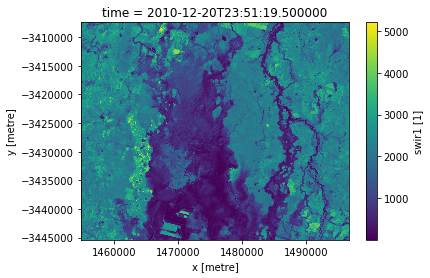

In [7]:
# View extent
%matplotlib inline
nbar_clean.swir1.isel(time=0).plot()

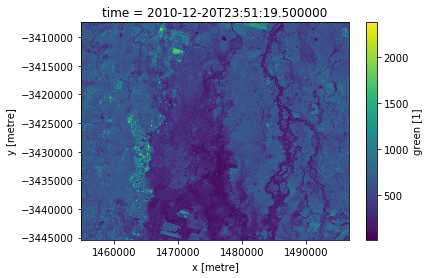

In [39]:
nbar_clean.green.isel(time=0).plot()

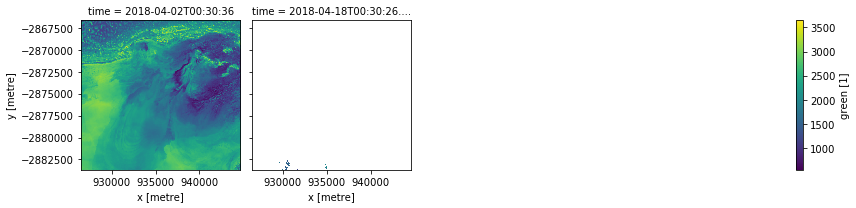

In [23]:
ntimes=len(nbar_clean.time.values)
nbar_clean.isel(time=slice(0,ntimes,1)).green.plot.imshow(col='time', col_wrap=4)

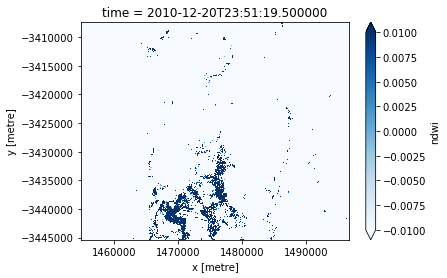

In [8]:
# Calculate and view NDWI
nbar_clean['ndwi']=(nbar_clean.green.astype(float) - nbar_clean.swir1.astype(float))/(nbar_clean.green.astype(float) + nbar_clean.swir1.astype(float))
#nbar_clean.isel(time=slice(0,ntimes,1)).ndwi.plot(col='time', col_wrap=4)
nbar_clean.ndwi.isel(time=0).plot(vmin=-0.01, vmax=0.01, cmap = 'Blues')

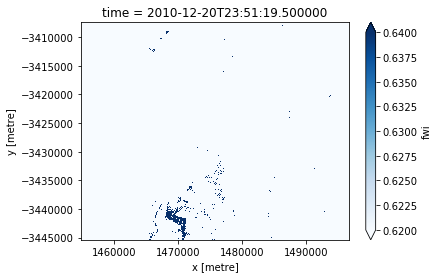

In [10]:
# Calculate and view Fischer's et al (2016) Wetness Index
nbar_clean['fwi']=(1.7204+171.0*nbar_clean.green.astype(float)+3.0*nbar_clean.red.astype(float)-70.0*nbar_clean.nir.astype(float)-45.0*nbar_clean.swir1.astype(float)-71.0*nbar_clean.swir2.astype(float))
nbar_clean.fwi.isel(time=0).plot(vmin=0.62, vmax=0.64, cmap = 'Blues')

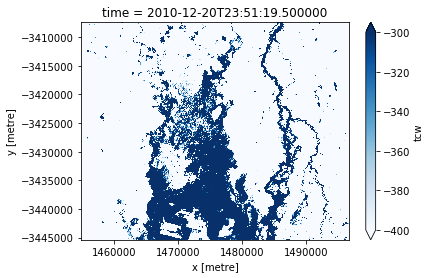

In [11]:
# calculate and view the Tasseled Cap Wetness (GA uses -350 threshold for water)
nbar_clean['tcw']=(0.0315*nbar_clean.blue.astype(float)+0.2021*nbar_clean.green.astype(float)+0.3102*nbar_clean.red.astype(float)+0.1594*nbar_clean.nir.astype(float)-0.6806*nbar_clean.swir1.astype(float)-0.6109*nbar_clean.swir2.astype(float))
nbar_clean.tcw.isel(time=0).plot(vmin=-400, vmax=-300, cmap = 'Blues')

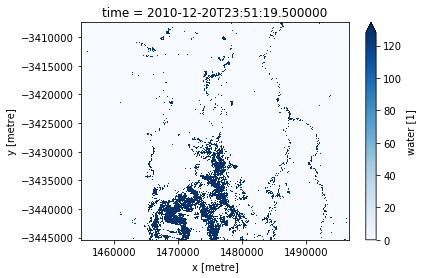

In [12]:
# Load and view WOfS water
wofs = dc.load(product= 'wofs_albers', group_by='solar_day',  **query)
wofs.water.isel(time=1).plot(vmin=0.0,vmax=128.0, cmap = 'Blues')

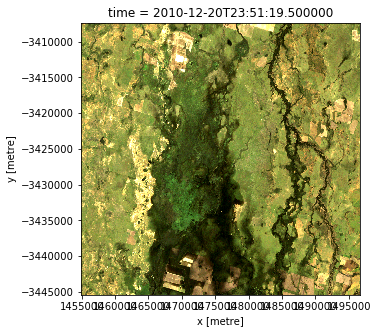

In [17]:
# View RGB image
image_array = nbar_clean[['red', 'green', 'blue']].isel(time=0).to_array()
image_array.plot.imshow(robust=True, figsize = (5,5));

In [18]:
# write output images (in Albers) to GeoTIFF

import ogr, gdal, osr
import numpy as np

# define coordinates for Albers equal area (3577)
xcoords = nbar_clean.isel(time=0).green.indexes['x']
ycoords = nbar_clean.isel(time=0).green.indexes['y']
yt,xt = nbar_clean.isel(time=0).green.shape
MaxValX = xcoords.shape
MaxValY = ycoords.shape

# set geotransform and output projection
xres = 25 
yres = 25 
# geotransform required when np.flip is used in image
geotransform = (xcoords[MaxValX[0]-1]-(xres*0.5), xres, 0, ycoords[MaxValY[0]-1]+(yres*0.5), 0, -yres) # offset by half the pixel size since it needs to be top-left pixel coord
# geotransform required when np.flip is not used in image
#geotransform = (xcoords[0]-(xres*0.5), xres, 0, ycoords[0]+(yres*0.5), 0, -yres) # offset by half the pixel size since it needs to be top-left pixel coord
srs = osr.SpatialReference() 
srs.ImportFromEPSG(3577)

# can loop through multiple images, but currently only uses one
images = ['Dec2019']

# Edit output filenames and directory as required
for image in images:
    
    filename = 'LS_MacMarshes_RGB_3577_'+ month+'.tif' 
    #S1_ds = gdal.GetDriverByName('GTiff').Create('/g/data/r78/cjt599/'+filename, 
    #                                               xt, yt, 1, gdal.GDT_Float32) # for single band image
    S1_ds = gdal.GetDriverByName('GTiff').Create('/g/data/r78/cjt599/'+filename, 
                                                   xt, yt, 3, gdal.GDT_Float32) # for RGB image
    S1_ds.SetGeoTransform(geotransform) # specify coordinates
    S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    #S1_ds.GetRasterBand(1).WriteArray(np.flip(nbar_clean.ndwi.isel(time=0)).data)
    #S1_ds.GetRasterBand(1).WriteArray(np.flip(nbar_clean.fwi.isel(time=0)).data)
    #S1_ds.GetRasterBand(1).WriteArray(np.flip(nbar_clean.tcw.isel(time=0)).data)
    #S1_ds.GetRasterBand(1).WriteArray(np.flip(wofs.water.isel(time=1)).data)
    S1_ds.GetRasterBand(1).WriteArray(np.flip(nbar_clean.red.isel(time=0)).data)
    S1_ds.GetRasterBand(2).WriteArray(np.flip(nbar_clean.green.isel(time=0)).data)
    S1_ds.GetRasterBand(3).WriteArray(np.flip(nbar_clean.blue.isel(time=0)).data)
    S1_ds.FlushCache()  # write to file
    S1_ds = None # save and close